In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.recorder import TrainRecorder
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.deit import DeiT, HardDistillation
from torchlake.image_classification.controller.trainer_deit import DeiTTrainer
from torchvision import transforms
from torchvision.datasets import Food101
from torchlake.common.controller.weight_manager import WeightManager

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/deit")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/food101")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(0, 1),
    ]
)

In [6]:
train_dataset = Food101(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(train_dataset.classes)
num_class

101

# model

In [9]:
# DOWNSCALE_FACTOR = 4

In [10]:
model = DeiT(
    output_size=num_class,
    image_size=IMAGE_SIZE,
    # which is 16x16, I write calculation explicitly for flexibility. you can just assign 16
    patch_size=IMAGE_SIZE // 14,
    # 4 times smaller than base
    # embed_dim=768 // DOWNSCALE_FACTOR,  
    # hidden_dim=3072 // DOWNSCALE_FACTOR,
    # num_head=12,  # same as base
    # num_encoder_layers=12,
    size="tiny", 
).to(device)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
DeiT                                                              --
├─ModuleDict: 1-1                                                 --
│    └─PositionEncoding1d: 2-1                                    38,016
│    └─ChannelVector: 2-2                                         192
│    └─ChannelVector: 2-3                                         192
│    └─Sequential: 2-4                                            --
│    │    └─Conv2d: 3-1                                           147,648
│    │    └─Flatten: 3-2                                          --
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─TransformerEncoderLayer: 3-3                          444,864
│    │    └─TransformerEncoderLayer: 3-4                          444,864
│    │    └─TransformerEncoderLayer: 3-5                          444,864
│  

In [12]:
from torchvision.models import regnet_y_16gf
from torch import nn

In [13]:
t_model = regnet_y_16gf(weights="DEFAULT")
t_model.fc = nn.Linear(3024, num_class)
t_model = t_model.to(device)

In [14]:
manager = WeightManager(artifact_path.joinpath("teacher.pth").as_posix())
model_path = manager.get_filename()
model_path

WindowsPath('../../artifacts/deit/teacher.pth')

In [15]:
manager.load_weight(model_path, t_model)

# training

In [16]:
epochs = 10

In [17]:
trainer = DeiTTrainer(epochs, device)

In [18]:
criterion = HardDistillation(alpha=0.5, smooth=0.1)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [19]:
recorder = TrainRecorder(total_epoch=epochs)
recorder.increment_data_size(len(train_dataset))

In [20]:
scaler = torch.cuda.amp.GradScaler()

In [21]:
_ = trainer.run(
    train_loader,
    model,
    optim,
    criterion,
    scaler=scaler,
    recorder=recorder,
    t_model=t_model,
)

Enable AMP: True
Training...


100%|██████████| 2367/2367 [10:22<00:00,  3.80it/s]


Epoch 1 : 0.13750963960150311 (0%)


100%|██████████| 2367/2367 [10:21<00:00,  3.81it/s]


Epoch 2 : 0.12243491752548973 (-11%)


100%|██████████| 2367/2367 [10:13<00:00,  3.86it/s]


Epoch 3 : 0.1157352342479692 (-5%)


100%|██████████| 2367/2367 [10:18<00:00,  3.82it/s]


Epoch 4 : 0.11106580449409595 (-4%)


100%|██████████| 2367/2367 [10:01<00:00,  3.93it/s]


Epoch 5 : 0.10740334998026949 (-3%)


100%|██████████| 2367/2367 [10:01<00:00,  3.94it/s]


Epoch 6 : 0.10474317363386501 (-2%)


100%|██████████| 2367/2367 [10:03<00:00,  3.92it/s]


Epoch 7 : 0.10220993549989002 (-2%)


100%|██████████| 2367/2367 [10:02<00:00,  3.93it/s]


Epoch 8 : 0.10001399034556792 (-2%)


100%|██████████| 2367/2367 [10:04<00:00,  3.92it/s]


Epoch 9 : 0.09814917657871063 (-2%)


100%|██████████| 2367/2367 [10:05<00:00,  3.91it/s]

Epoch 10 : 0.09648980453856328 (-2%)


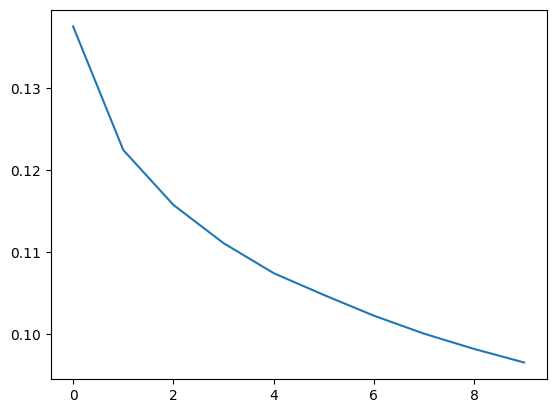

In [22]:
plt.plot(recorder.training_losses[0])

# inference

In [23]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1),
])

In [24]:
test_dataset = Food101(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [25]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [26]:
evaluator = ClassificationEvaluator(num_class, device)

In [27]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 790/790 [02:51<00:00,  4.62it/s]

[[ 18   0  42 ...   2   1   0]
 [  0 134   3 ...   1   0   0]
 [  3   2 167 ...   1   1   1]
 ...
 [  6   1   8 ...  87   0   1]
 [  0   0   5 ...   0  58   0]
 [  3   3   2 ...   0   0  41]]


In [28]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

apple_pie : 0.072
baby_back_ribs: 0.536
baklava   : 0.668
beef_carpaccio: 0.648
beef_tartare: 0.348
beet_salad: 0.492
beignets  : 0.54
bibimbap  : 0.692
bread_pudding: 0.144
breakfast_burrito: 0.032
bruschetta: 0.4
caesar_salad: 0.688
cannoli   : 0.188
caprese_salad: 0.756
carrot_cake: 0.34
ceviche   : 0.108
cheese_plate: 0.064
cheesecake: 0.412
chicken_curry: 0.188
chicken_quesadilla: 0.148
chicken_wings: 0.584
chocolate_cake: 0.456
chocolate_mousse: 0.352
churros   : 0.196
clam_chowder: 0.46
club_sandwich: 0.184
crab_cakes: 0.224
creme_brulee: 0.588
croque_madame: 0.396
cup_cakes : 0.252
deviled_eggs: 0.568
donuts    : 0.072
dumplings : 0.496
edamame   : 0.672
eggs_benedict: 0.496
escargots : 0.24
falafel   : 0.292
filet_mignon: 0.312
fish_and_chips: 0.504
foie_gras : 0.052
french_fries: 0.488
french_onion_soup: 0.392
french_toast: 0.096
fried_calamari: 0.36
fried_rice: 0.528
frozen_yogurt: 0.2
garlic_bread: 0.232
gnocchi   : 0.208
greek_salad: 0.448
grilled_cheese_sandwich: 0.052
gr

In [29]:
per_class_acc.mean()

0.3706534653465346

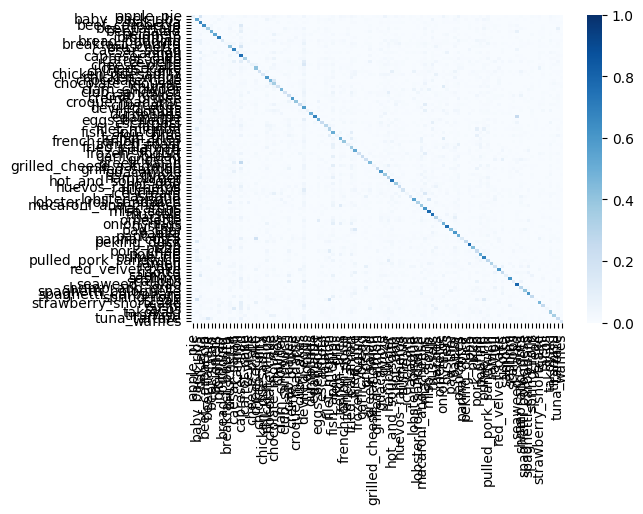

In [30]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [31]:
manager = WeightManager(artifact_path.joinpath("deit.{dim}.{psize}x{psize}.pth").as_posix())

In [32]:
model_path = manager.get_filename(dim=model.embed_dim, psize=model.patch_size)

In [33]:
model_path

WindowsPath('../../artifacts/deit/deit.192.16x16.pth')

In [34]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\deit\deit.192.16x16.pth, model size is 21.28MiB


In [35]:
manager.load_weight(model_path, model)

# Teacher finetuning

In [28]:
from torch import nn
from torchlake.common.controller.trainer import ClassificationTrainer
from torchvision.models import regnet_y_16gf

In [29]:
t_model = regnet_y_16gf(weights="DEFAULT")
t_model.fc = nn.Linear(3024, num_class)
t_model = t_model.to(device)

In [30]:
torchinfo.summary(t_model)

Layer (type:depth-idx)                                  Param #
RegNet                                                  --
├─SimpleStemIN: 1-1                                     --
│    └─Conv2d: 2-1                                      864
│    └─BatchNorm2d: 2-2                                 64
│    └─ReLU: 2-3                                        --
├─Sequential: 1-2                                       --
│    └─AnyStage: 2-4                                    --
│    │    └─ResBottleneckBlock: 3-1                     295,912
│    │    └─ResBottleneckBlock: 3-2                     352,856
│    └─AnyStage: 2-5                                    --
│    │    └─ResBottleneckBlock: 3-3                     907,256
│    │    └─ResBottleneckBlock: 3-4                     956,592
│    │    └─ResBottleneckBlock: 3-5                     956,592
│    │    └─ResBottleneckBlock: 3-6                     956,592
│    └─AnyStage: 2-6                                    --
│    │    └─ResBottl

In [31]:
epochs = 10

In [32]:
trainer = ClassificationTrainer(epochs, device)

In [33]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(t_model.parameters(), lr=1e-4)

In [34]:
recorder = TrainRecorder(total_epoch=epochs)
recorder.increment_data_size(len(train_dataset))

In [35]:
scaler = torch.cuda.amp.GradScaler()

In [36]:
_ = trainer.run(
    train_loader,
    t_model,
    optim,
    criterion,
    scaler=scaler,
    recorder=recorder,
)

Enable AMP: True
Training...


100%|██████████| 2367/2367 [24:39<00:00,  1.60it/s]


Epoch 1 : 0.03559552038797844 (0%)


100%|██████████| 2367/2367 [15:18<00:00,  2.58it/s]


Epoch 2 : 0.01427670144449568 (-60%)


100%|██████████| 2367/2367 [15:02<00:00,  2.62it/s]


Epoch 3 : 0.008125549614380284 (-43%)


100%|██████████| 2367/2367 [14:15<00:00,  2.77it/s]


Epoch 4 : 0.00521765699835106 (-36%)


100%|██████████| 2367/2367 [14:21<00:00,  2.75it/s]


Epoch 5 : 0.003850033546094062 (-26%)


100%|██████████| 2367/2367 [14:48<00:00,  2.66it/s]


Epoch 6 : 0.0030946697991083207 (-20%)


100%|██████████| 2367/2367 [15:00<00:00,  2.63it/s]


Epoch 7 : 0.002640441828680906 (-15%)


100%|██████████| 2367/2367 [14:13<00:00,  2.77it/s]


Epoch 8 : 0.002313675472740295 (-12%)


100%|██████████| 2367/2367 [13:47<00:00,  2.86it/s]


Epoch 9 : 0.0021755529304247085 (-6%)


100%|██████████| 2367/2367 [13:14<00:00,  2.98it/s]

Epoch 10 : 0.0020406523615416924 (-6%)


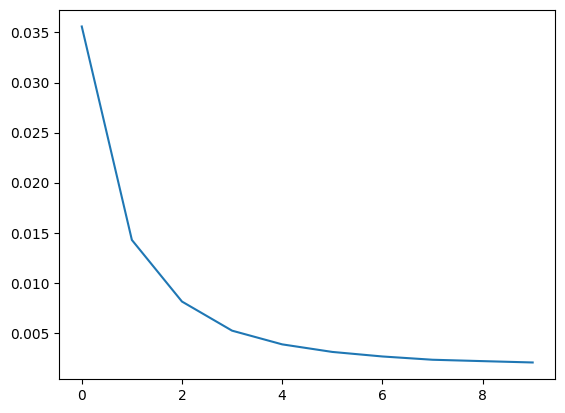

In [37]:
plt.plot(recorder.training_losses[0])

In [38]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1),
])

In [39]:
test_dataset = Food101(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [40]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [41]:
evaluator = ClassificationEvaluator(num_class, device)

In [42]:
confusion_matrix = evaluator.run(test_loader, t_model)

100%|██████████| 790/790 [09:10<00:00,  1.44it/s]

[[183   0   6 ...   0   2   5]
 [  0 217   0 ...   0   0   0]
 [  2   0 240 ...   0   0   1]
 ...
 [  2   0   2 ... 206   0   0]
 [  0   0   0 ...   0 191   0]
 [  1   1   0 ...   0   0 233]]


In [43]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

apple_pie : 0.732
baby_back_ribs: 0.868
baklava   : 0.96
beef_carpaccio: 0.924
beef_tartare: 0.904
beet_salad: 0.804
beignets  : 0.932
bibimbap  : 0.96
bread_pudding: 0.748
breakfast_burrito: 0.808
bruschetta: 0.74
caesar_salad: 0.936
cannoli   : 0.928
caprese_salad: 0.904
carrot_cake: 0.852
ceviche   : 0.684
cheese_plate: 0.952
cheesecake: 0.728
chicken_curry: 0.84
chicken_quesadilla: 0.916
chicken_wings: 0.928
chocolate_cake: 0.772
chocolate_mousse: 0.752
churros   : 0.928
clam_chowder: 0.932
club_sandwich: 0.888
crab_cakes: 0.796
creme_brulee: 0.94
croque_madame: 0.952
cup_cakes : 0.924
deviled_eggs: 0.976
donuts    : 0.888
dumplings : 0.916
edamame   : 0.992
eggs_benedict: 0.86
escargots : 0.956
falafel   : 0.904
filet_mignon: 0.832
fish_and_chips: 0.924
foie_gras : 0.756
french_fries: 0.956
french_onion_soup: 0.896
french_toast: 0.788
fried_calamari: 0.888
fried_rice: 0.9
frozen_yogurt: 0.928
garlic_bread: 0.836
gnocchi   : 0.796
greek_salad: 0.872
grilled_cheese_sandwich: 0.872
g

In [44]:
per_class_acc.mean()

0.8727920792079207

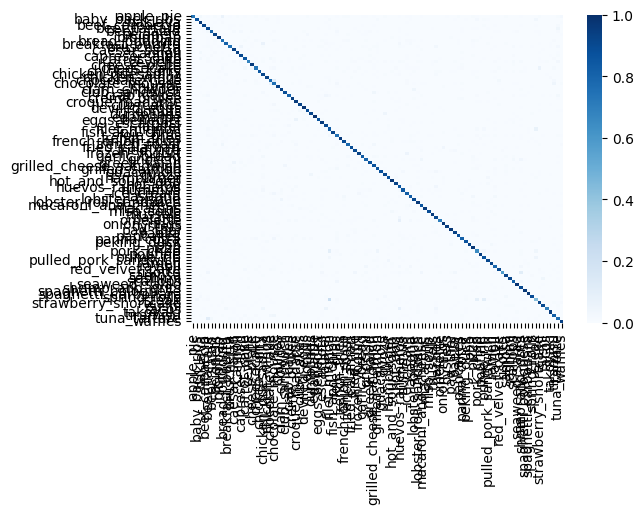

In [45]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [46]:
manager = WeightManager(artifact_path.joinpath("teacher.pth").as_posix())

In [47]:
model_path = manager.get_filename()

In [48]:
model_path

WindowsPath('../../artifacts/deit/teacher.pth')

In [49]:
manager.save_weight(t_model.state_dict(), model_path)

Save weight to ..\..\artifacts\deit\teacher.pth, model size is 309.12MiB


In [50]:
manager.load_weight(model_path, t_model)